# Loading Modules

In [46]:
%matplotlib inline

import seaborn as sns
import numpy as np
import pandas as pd
import csv
import datetime
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix, classification_report, recall_score, precision_recall_curve
from sklearn.cross_validation import train_test_split, cross_val_score, KFold
from patsy import dmatrices
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.naive_bayes import BernoulliNB
from sklearn.grid_search import GridSearchCV
import statsmodels.api as sm
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import LinearSVC

In [132]:
def prob_adjusted_outcome(model_probabilities,threshold):
    y_adjusted=[]
    for prob in model_probabilities:
        if prob[1] > threshold:
            y_adjusted.append(True)
        else:
            y_adjusted.append(False)
    return y_adjusted

# Loading Dataset and Reordering Data

In [2]:
filename='ATA_data.csv'

In [3]:
df = pd.read_csv(filename)
df=df.drop('Unnamed: 0',1)

In [4]:
df.columns.unique()

array(['datetime', 'advertiser_bundle_id', 'creative_id', 'ad_id',
       'app_id', 'bidadop_id', 'app_name', 'app_categories',
       'publisher_name', 'device_idfa', 'os', 'osv', 'make', 'model',
       'country', 'city', 'language', 'impression', 'clicked', 'installed',
       'app_type', 'weekday', 'hours'], dtype=object)

In [8]:
cats_to_keep=['entertainment', 'games', 'lifestyle', 'music', 'photography', 'productivity', 
             'social_networking', 'sports', 'travel', 'utilities']

In [9]:
df_clean2=df_clean1[df_clean1.app_type.isin(cats_to_keep)]

#### Taking interesting features

In [10]:
cols_to_keep=['installed','clicked','impression','app_type','weekday','hours']
filtered_df=df_clean2[cols_to_keep]

### Downsampling, remove the majority class by user set percentage

In [11]:
False_df=filtered_df[filtered_df['installed'] == False]
Truth_df=filtered_df[filtered_df['installed'] == True]

target_downsampling = 0.50;
downsampling=int(np.round((Truth_df.shape[0]/target_downsampling)*(1-target_downsampling)))

#Downsampling by target downsample rate
Downsampled_False=resample(False_df, n_samples=downsampling, random_state=0, replace = False)

# Merge the downsampled False with total True outcomes
less_imbalance=pd.concat([Downsampled_False,Truth_df])

In [14]:
#No downsampling dataset
clean_data=filtered_df

## Creating the dummy variables.

### Quick dirty comparison of AUC of ROC 

<p> Comparing the ROC_AUC of the complete dataset vs. downsampled dataset. This is used as an indication of model stability. </p>

<p> 

Use patsy to create the dummy variable

In [15]:
y_com,X_com = dmatrices('installed ~ hours + C(weekday) + C(app_type)'
               ,clean_data, return_type='dataframe'
               )

In [18]:
y_com=np.ravel(y_com.iloc[:,1:])

In [166]:
y_com

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

In [29]:
roc_auc_com= cross_val_score(LogisticRegression(class_weight='auto', fit_intercept=False),
                          X_com, y_com, scoring='roc_auc', cv =5)

In [39]:
y,X = dmatrices('installed ~ hours + C(weekday) + C(app_type)'
               ,less_imbalance, return_type='dataframe'
               )

In [40]:
y=np.ravel(y.iloc[:,1:])

In [41]:
roc_auc_dsampled= cross_val_score(LogisticRegression(class_weight='auto', fit_intercept=False),
                          X, y, scoring='roc_auc', cv =5)

In [44]:
roc_auc_diff= np.mean(roc_auc_com - roc_auc_dsampled)
print roc_auc_diff

0.00907950695745


## Running different models.

In [64]:
rm=[LogisticRegression(fit_intercept=False), RandomForestClassifier(), LinearSVC(), GradientBoostingClassifier(max_depth=3)]
cvs=5
model_aucs=np.empty((len(rm),cvs))
model_recalls=np.empty((len(rm),cvs))
model_precision=np.empty((len(rm),cvs))

for i,models in enumerate(rm):
    
    model_recalls[i,:] = cross_val_score(models, X, y, scoring = 'recall', cv = cvs)
    model_precision[i,:] = cross_val_score(models, X, y, scoring = 'precision', cv = cvs)
    model_aucs[i,:] = cross_val_score(models, X, y, scoring = 'roc_auc', cv = cvs)


In [69]:
summary_matrices = np.empty((6,len(rm)))
summary_matrices[0, :] = np.mean(model_recalls, axis=1)
summary_matrices[1, :] = np.std(model_recalls, axis = 1)
summary_matrices[2, :] = np.mean(model_precision, axis=1)
summary_matrices[3, :] = np.std(model_precision, axis = 1)
summary_matrices[4, :] = np.mean(model_aucs, axis=1)
summary_matrices[5, :] = np.std(model_aucs, axis = 1)

In [70]:
summary_df=pd.DataFrame(summary_matrices)
summary_df.columns=['Logistic Regression', 'Random Forest', 'Linear SVC', 'GradientBoostClassifier']
summary_df.index=['Recall mean', 'Recall std', 'Precision mean', 'Precision std', 'ROC_AUC mean', 'ROC_AUC std']

In [71]:
summary_df

,Logistic Regression,Random Forest,Linear SVC,GradientBoostClassifier
Recall mean,0.718492,0.584985,0.760059,0.648530
Recall std,0.132833,0.016076,0.067455,0.059857
Precision mean,0.537776,0.545529,0.541720,0.551129
Precision std,0.031245,0.009489,0.024927,0.023980
ROC_AUC mean,0.559329,0.542976,0.558990,0.566703
ROC_AUC std,0.036102,0.026191,0.032048,0.027623


#### Using 90% of data to train.

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

## Logistic Regression 

In [79]:
modelLogR2 = LogisticRegression(class_weight='auto',fit_intercept=False);
modelLogR2.fit(X_train, y_train);

In [80]:
pd.DataFrame(zip(X_train.columns, np.transpose(modelLogR2.coef_)))

,0,1
0,Intercept,[-0.851950796261]
1,C(weekday)[T.2],[-0.176030318048]
2,C(weekday)[T.3],[-0.510803933691]
3,C(weekday)[T.4],[-0.386893067098]
4,C(weekday)[T.5],[-0.147138849184]
5,C(weekday)[T.6],[-0.0718215278983]
6,C(weekday)[T.7],[0.0805889013225]
7,C(app_type)[T.games],[1.03653052008]
8,C(app_type)[T.lifestyle],[0.0977921414728]
9,C(app_type)[T.music],[-0.471685951065]


In [81]:
#Use Training Set to verify if model is learning anything
verify_train = modelLogR2.predict(X_train)
prob_train = modelLogR2.predict_proba(X_train)
recall_score(y_train,verify_train)




0.79076479076479078

In [82]:
#metrics for recall and confusion matrix

print confusion_matrix(y_train, verify_train, labels=[True, False]).transpose()
print classification_report(y_train, verify_train)

[[269 425]
 [145 548]]
             precision    recall  f1-score   support

        0.0       0.65      0.39      0.49       694
        1.0       0.56      0.79      0.66       693

avg / total       0.61      0.59      0.57      1387



In [83]:
#Prediction using test set
predictedLR2 = modelLogR2.predict(X_test)
probLR2 = modelLogR2.predict_proba(X_test)
recall_score(y_test,predictedLR2)




0.80769230769230771

In [102]:
#metrics for recall and confusion matrix

cm = confusion_matrix(y_test, predictedLR2, labels=[True, False]).transpose()
print cm
print classification_report(y_test, predictedLR2)

[[63 43]
 [15 34]]
             precision    recall  f1-score   support

        0.0       0.69      0.44      0.54        77
        1.0       0.59      0.81      0.68        78

avg / total       0.64      0.63      0.61       155



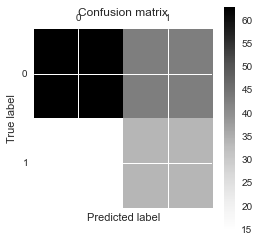

In [101]:
plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label');
plt.xlabel('Predicted label');

In [87]:
y_adjusted=prob_adjusted_outcome(probLR2,0.5)

In [88]:
print classification_report(y_test, y_adjusted)

             precision    recall  f1-score   support

        0.0       0.71      0.42      0.52       240
        1.0       0.57      0.82      0.67       223

avg / total       0.64      0.61      0.59       463



In [103]:
def prob_class_outcome(model_probabilities,select_class):
    prob_class=[]
    for prob in model_probabilities:
            prob_class.append(prob[select_class])
    return prob_class

In [104]:
y_prob=prob_class_outcome(probLR2,1)

In [176]:
np.sum(np.array(y_prob))/np.sum(y_test)

0.97247562985234504

In [175]:
np.sum(y_test)

78.0

In [ ]:

# Precision Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test,y_prob)

In [ ]:
plt.plot(recall,precision)

### Gradient Boosting Classifier

In [105]:
modelGBC = GradientBoostingClassifier();
modelGBC.fit(X_train, y_train);

In [109]:
pd.DataFrame(zip(X_train.columns, np.transpose(modelGBC.feature_importances_)))

,0,1
0,Intercept,0.000000
1,C(weekday)[T.2],0.030280
2,C(weekday)[T.3],0.027567
3,C(weekday)[T.4],0.058737
4,C(weekday)[T.5],0.042074
5,C(weekday)[T.6],0.058672
6,C(weekday)[T.7],0.064534
7,C(app_type)[T.games],0.104827
8,C(app_type)[T.lifestyle],0.024214
9,C(app_type)[T.music],0.012595


In [110]:
#Use Training Set to verify if model is learning anything
verify_train = modelGBC.predict(X_train)
prob_train = modelGBC.predict_proba(X_train)
recall_score(y_train,verify_train)

0.73737373737373735

In [115]:
#metrics for recall and confusion matrix

print confusion_matrix(y_train, verify_train, labels=[True, False]).transpose()
print classification_report(y_train, verify_train)

[[511 316]
 [182 378]]
             precision    recall  f1-score   support

        0.0       0.68      0.54      0.60       694
        1.0       0.62      0.74      0.67       693

avg / total       0.65      0.64      0.64      1387



In [119]:
#Prediction using test set
predictedGBC = modelGBC.predict(X_test)
probGBC = modelGBC.predict_proba(X_test)
recall_score(y_test,predictedGBC)

0.66666666666666663

In [121]:
#metrics for recall and confusion matrix

cm = confusion_matrix(y_test, predictedGBC, labels=[True, False]).transpose()
print cm
print classification_report(y_test, predictedGBC)

[[52 30]
 [26 47]]
             precision    recall  f1-score   support

        0.0       0.64      0.61      0.63        77
        1.0       0.63      0.67      0.65        78

avg / total       0.64      0.64      0.64       155



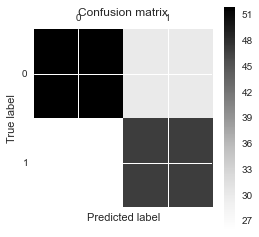

In [122]:
plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label');
plt.xlabel('Predicted label');

In [151]:
np.mean(y_test)

0.50322580645161286

#### Rank Users based on predicted probabilities

In [149]:
ranked_df=pd.DataFrame(predictedGBC)
ranked_df['Probabilities'] = prob_class_outcome(probGBC,1)
ranked_df.columns=['Predicted Outcomes','Probabilities']
ranked_df.sort(columns='Probabilities')

,Predicted Outcomes,Probabilities
95,0,0.029007
116,0,0.039756
148,0,0.068227
139,0,0.093016
47,0,0.101334
68,0,0.107609
97,0,0.122060
119,0,0.123496
1,0,0.136732
99,0,0.143720


In [163]:
rank_percentile = np.percentile(ranked_df['Probabilities'],1)

(array([  5.,   7.,   6.,   6.,   6.,  29.,  48.,  29.,  16.,   3.]),
 array([ 0.02900706,  0.10578098,  0.18255489,  0.2593288 ,  0.33610272,
         0.41287663,  0.48965054,  0.56642445,  0.64319837,  0.71997228,
         0.79674619]),
 <a list of 10 Patch objects>)

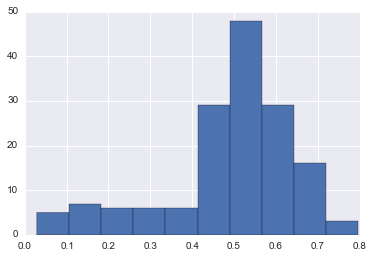

In [164]:
plt.hist(ranked_df['Probabilities'])

In [165]:
rank_percentile

0.055130201134408675

### Random Forests

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)
modelRandomForest= RandomForestClassifier(class_weight='auto', n_estimators=100)
modelRandomForest.fit(X_train, y_train)

In [ ]:
# Random Forest Predictions
predictedRF = modelRandomForest.predict(X_train)
probs = modelRandomForest.predict_proba(X_train)

In [ ]:
# Look at precision/recall and confusion matrix

print confusion_matrix(y_train,predictedRF)
print classification_report(y_train,predictedRF)

In [ ]:
param_grid = {"max_depth": [3, None],
              "max_features": [1, 3, 10],
              "min_samples_split": [1, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

In [ ]:
grid_search = GridSearchCV(modelRandomForest, param_grid=param_grid)

In [ ]:
for params, mean_score, scores in ZZ.grid_scores_:
        print("%0.3f (+/-%0.03f) for %r"%(mean_score, scores.std() * 2, params))

In [ ]:
ZZ=grid_search.fit(X_train,y_train)

In [ ]:
ZZ.best_params_

In [ ]:
XX=ZZ.predict(X_test)

In [ ]:
print confusion_matrix(y_test,XX)
print classification_report(y_test,XX)